### Importing Libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

###  Reading and Cleaning Data

In [22]:
df = pd.read_csv('raw_data.csv')

df.drop([
    'url','address','online_order','book_table','phone','location','menu_item','listed_in(city)'
],axis=1,inplace=True)

df.rename({'approx_cost(for two people)':'approx_cost', 'listed_in(type)':'dining_type'},axis=1,inplace=True)

In [23]:
df.drop_duplicates(['name'],inplace=True)

In [24]:
df.shape

(8792, 9)

### Helper Functions

In [25]:
def convert_number(val):
    try: return float(val.strip('/5'))
    except: return -1
    
def get_n(val):
    try: return len(val)
    except: return 0
    
def get_first(val):
    try: return val[0]
    except: return 'Other'
    
def drop_outliers(value,df,threshold=1000):
    if df.loc[value]<threshold:
        return 'Other'
    return value

def convert_cost(val):
    try: return int(val.replace(',',''))
    except: return -1
    
def dollar_signs(val):
    if val==-1: return -1
    elif val<500: return 1
    elif val<1000: return 2
    elif val<2000: return 3
    else: return 4

### Transforming and Simplifying the Data

In [26]:
# CONVERT RATE TO FLOAT
df['rate'] = df.rate.apply(convert_number)

# EDIT REST_TYPE
df['rest_type_list'] = df.rest_type.str.split(',')
df['n_rest_types'] = df.rest_type_list.apply(get_n)
df['rest_type']=df.rest_type_list.apply(get_first)
rest_type_counts = df.rest_type.value_counts()
df['rest_type'] = df.rest_type.apply(drop_outliers,df=rest_type_counts,threshold=1000)

# EDIT CUISINES
df['cuisines_list'] = df.cuisines.str.split(',')
df['n_cuisines'] = df.cuisines_list.apply(get_n)
df['cuisines']=df.cuisines_list.apply(get_first)
cuisines_counts = df.cuisines.value_counts()
df['cuisines'] = df.cuisines.apply(drop_outliers,df=cuisines_counts,threshold=200)

# EDIT APPROX_COST
df['approx_cost'] = df.approx_cost.apply(convert_cost)
df['dollar_sign']=df.approx_cost.apply(dollar_signs)

# EDIT VOTES
df['votes'] = df.votes.apply(lambda x: x if x<5000 else 5000)

In [29]:
df.n_rest_types.value_counts()

1    7601
2    1149
0      42
Name: n_rest_types, dtype: int64

In [31]:
df.n_cuisines.value_counts()

2    3036
1    2472
3    1978
4     881
5     269
6      79
7      37
8      32
0       8
Name: n_cuisines, dtype: int64

In [32]:
df.shape

(8792, 14)

In [33]:
df = df[df.cuisines!='Other']
print(df.shape)
df = df[df.rest_type!='Other']
print(df.shape)
df = df[df.rate!=-1]
print(df.shape)
df = df[df.dollar_sign!=-1]
print(df.shape)

(6738, 14)
(4582, 14)
(3257, 14)
(3246, 14)


In [28]:
df[df.rate==-1].shape

(2460, 14)

In [ ]:
# DROP NA ROWS
df = df[(df.rate!=-1)&(df.dollar_sign!=-1)&(df.cuisines!='Other')&(df.rest_type!='Other')]
df.reset_index(inplace=True,drop=True)

### Differentiating 'Good' restaurants using K-Means Clustering:

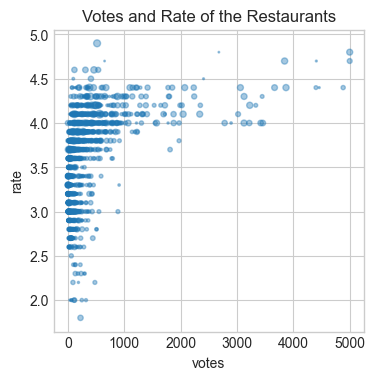

In [7]:
plt.scatter(df.votes, df.rate, s=df.approx_cost/80, alpha=0.4);
plt.title("Votes and Rate of the Restaurants");
plt.xlabel("votes");
plt.ylabel("rate");
plt.show()

In [8]:
x = df[['votes','rate']].values
min_max_scaler = MinMaxScaler()
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns=['votes_normalized','rate_normalized'])
df = pd.concat([df,x_scaled],axis=1)

#### Deciding K

In [9]:
print('cummulative variance when')
for K in range(3,10):
    kmeans = KMeans(n_clusters=K, random_state=0).fit(x_scaled)
    kmeans.labels_
    df["restaurant_value"] = kmeans.labels_
    variances = df.groupby('restaurant_value')[['votes_normalized','rate_normalized']].agg('var')
    print(f'   -> K={K} is:{variances.sum().sum()}')

cummulative variance when
   -> K=3 is:0.06336238929912955
   -> K=4 is:0.060965049179735095
   -> K=5 is:0.06003100721688928
   -> K=6 is:0.05188059499646844
   -> K=7 is:0.05428442056260695
   -> K=8 is:0.055898535382523096
   -> K=9 is:0.05599557272352117


In [10]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(x_scaled)
kmeans.labels_
df["restaurant_value"] = kmeans.labels_

In [11]:
df.restaurant_value.replace({3:-9,4:-8,1:-7,0:-6,5:-5,2:-4},inplace=True)
df['restaurant_value']=df.restaurant_value*(-1)-4

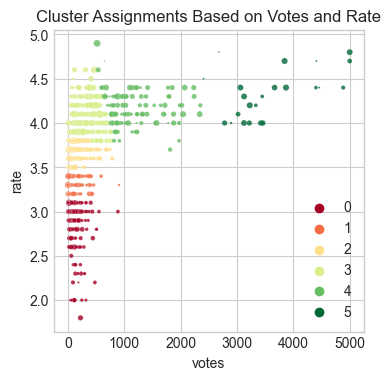

In [12]:
sns.scatterplot(data=df, x="votes", y="rate",
                s=df.approx_cost/80, alpha=0.8,
                hue=df['restaurant_value'].tolist(),
                palette="RdYlGn")
plt.title('Cluster Assignments Based on Votes and Rate')
plt.show()

In [13]:
# GENERATE LOCATIONS FOR RESTAURANTS USING NORMAL DISTRIBUTION
# sigma * np.random.randn(...) + mu
df['x'] = np.random.randn(df.shape[0])
df['y'] = np.random.randn(df.shape[0])

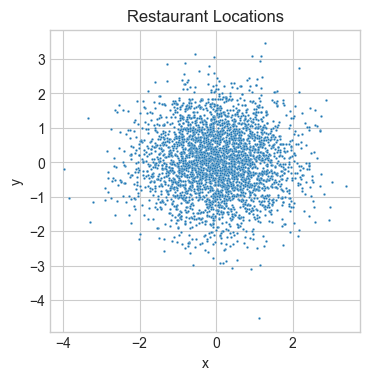

In [14]:
sns.scatterplot(data=df, x="x", y="y", alpha=1,
                s=3,
                palette="RdYlGn")
plt.title('Restaurant Locations')
plt.show()

In [15]:
# GENERATE FINAL TABLE
df = df[['name','cuisines','rest_type','rate','dollar_sign','restaurant_value','x','y']]

In [16]:
df['cuisines'] = df.cuisines.str.replace(" ","")
df['rest_type'] = df.rest_type.str.replace(" ","")

In [17]:
df.rest_type.value_counts().index.tolist()

['QuickBites', 'CasualDining']

In [18]:
df.cuisines.value_counts().index.tolist()

['NorthIndian',
 'SouthIndian',
 'Chinese',
 'FastFood',
 'Biryani',
 'Andhra',
 'Continental',
 'Desserts',
 'Cafe',
 'Bakery']

In [19]:
df.head()

,name,cuisines,rest_type,rate,dollar_sign,restaurant_value,x,y
0,Jalsa,NorthIndian,CasualDining,4.1,2,4,-0.643662,-0.714164
1,Spice Elephant,Chinese,CasualDining,4.1,2,4,-0.311299,0.597305
2,Addhuri Udupi Bhojana,SouthIndian,QuickBites,3.7,1,2,-1.033651,-0.974630
3,Grand Village,NorthIndian,CasualDining,3.8,2,2,-0.936532,-1.618117
4,Timepass Dinner,NorthIndian,CasualDining,3.8,2,2,0.873041,-0.409342


In [20]:
df.shape

(3246, 8)

In [98]:
# EXPORT DATA
df.to_csv('clean_data.csv',index=False)